# Solar Power Generation


In [112]:
import pandas as pd
import numpy as np

# 创建示例数据
data = {'A': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
df = pd.DataFrame(data)

# 对列'A'进行滚动平均操作
lag_feature = df['A'].rolling(4).mean()

# 输出结果
print("原始数据:")
print(df)
print("\n滚动平均结果:")
print(lag_feature)


原始数据:
    A
0   1
1   2
2   3
3   4
4   5
5   6
6   7
7   8
8   9
9  10

滚动平均结果:
0    NaN
1    NaN
2    NaN
3    2.5
4    3.5
5    4.5
6    5.5
7    6.5
8    7.5
9    8.5
Name: A, dtype: float64


In [113]:
lag_feature_shift = df['A'].shift(2).rolling(4).mean()

# 输出结果
print("输出结果:")
print(lag_feature_shift)
print("\n滚动平均结果:")
print(lag_feature)


输出结果:
0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    2.5
6    3.5
7    4.5
8    5.5
9    6.5
Name: A, dtype: float64

滚动平均结果:
0    NaN
1    NaN
2    NaN
3    2.5
4    3.5
5    4.5
6    5.5
7    6.5
8    7.5
9    8.5
Name: A, dtype: float64


## Preparation


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn import ensemble
from sklearn.metrics import r2_score, mean_squared_error

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.optim as optim


for dirname, _, filenames in os.walk("Kaggle\input\solar-power-generation-data"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Kaggle\input\solar-power-generation-data\Plant_1_Generation_Data.csv
Kaggle\input\solar-power-generation-data\Plant_1_Weather_Sensor_Data.csv
Kaggle\input\solar-power-generation-data\Plant_2_Generation_Data.csv
Kaggle\input\solar-power-generation-data\Plant_2_Weather_Sensor_Data.csv


In [5]:
# Data Loading
generation_data_plant_1 = pd.read_csv("Kaggle\input\solar-power-generation-data/Plant_1_Generation_Data.csv")
weather_data_plant_1 = pd.read_csv("Kaggle\input\solar-power-generation-data/Plant_1_Weather_Sensor_Data.csv")
generation_data_plant_2 = pd.read_csv("Kaggle\input\solar-power-generation-data/Plant_2_Generation_Data.csv")
weather_data_plant_2 = pd.read_csv("Kaggle\input\solar-power-generation-data/Plant_2_Weather_Sensor_Data.csv")

In [6]:
generation_data_plant_1_head = generation_data_plant_1.head()
weather_data_plant_1_head = weather_data_plant_1.head()
generation_data_plant_2_head = generation_data_plant_2.head()
weather_data_plant_2_head = weather_data_plant_2.head()

generation_data_plant_1_head, weather_data_plant_1_head
generation_data_plant_2_head, weather_data_plant_2_head

(             DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  \
 0  2020-05-15 00:00:00   4136001  4UPUqMRk7TRMgml       0.0       0.0   
 1  2020-05-15 00:00:00   4136001  81aHJ1q11NBPMrL       0.0       0.0   
 2  2020-05-15 00:00:00   4136001  9kRcWv60rDACzjR       0.0       0.0   
 3  2020-05-15 00:00:00   4136001  Et9kgGMDl729KT4       0.0       0.0   
 4  2020-05-15 00:00:00   4136001  IQ2d7wF4YD8zU1Q       0.0       0.0   
 
    DAILY_YIELD   TOTAL_YIELD  
 0  9425.000000  2.429011e+06  
 1     0.000000  1.215279e+09  
 2  3075.333333  2.247720e+09  
 3   269.933333  1.704250e+06  
 4  3177.000000  1.994153e+07  ,
              DATE_TIME  PLANT_ID       SOURCE_KEY  AMBIENT_TEMPERATURE  \
 0  2020-05-15 00:00:00   4136001  iq8k7ZNt4Mwm3w0            27.004764   
 1  2020-05-15 00:15:00   4136001  iq8k7ZNt4Mwm3w0            26.880811   
 2  2020-05-15 00:30:00   4136001  iq8k7ZNt4Mwm3w0            26.682055   
 3  2020-05-15 00:45:00   4136001  iq8k7ZNt4Mwm3w0           

## Data Exploration


### Data Cleaning


In [7]:
generation_data_plant_1_missing_values = generation_data_plant_1.isnull().sum()
weather_data_plant_1_missing_values = weather_data_plant_1.isnull().sum()
generation_data_plant_2_missing_values = generation_data_plant_2.isnull().sum()
weather_data_plant_2_missing_values = weather_data_plant_2.isnull().sum()

print(generation_data_plant_1_missing_values)
print(weather_data_plant_1_missing_values)
print(generation_data_plant_2_missing_values)
print(weather_data_plant_2_missing_values)

DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64
DATE_TIME              0
PLANT_ID               0
SOURCE_KEY             0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64
DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64
DATE_TIME              0
PLANT_ID               0
SOURCE_KEY             0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64


In [8]:
# Convert DATE_TIME columns to datetime
generation_data_plant_1["DATE_TIME"] = pd.to_datetime(
    generation_data_plant_1["DATE_TIME"], format="%d-%m-%Y %H:%M"
)
weather_data_plant_1["DATE_TIME"] = pd.to_datetime(
    weather_data_plant_1["DATE_TIME"], format="%Y-%m-%d %H:%M:%S"
)
generation_data_plant_2["DATE_TIME"] = pd.to_datetime(
    generation_data_plant_2["DATE_TIME"], format="%Y-%m-%d %H:%M:%S"
)
weather_data_plant_2["DATE_TIME"] = pd.to_datetime(
    weather_data_plant_2["DATE_TIME"], format="%Y-%m-%d %H:%M:%S"
)

#### Plant 1


In [9]:
generation_data_plant_1.drop(["PLANT_ID"], axis=1, inplace=True)
weather_data_plant_1.drop(["PLANT_ID", "SOURCE_KEY"], axis=1, inplace=True)

generation_data_plant_1.head(), weather_data_plant_1.tail()

(   DATE_TIME       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD
 0 2020-05-15  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6259559.0
 1 2020-05-15  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6183645.0
 2 2020-05-15  3PZuoBAID5Wc2HD       0.0       0.0          0.0    6987759.0
 3 2020-05-15  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7602960.0
 4 2020-05-15  McdE0feGgRqW7Ca       0.0       0.0          0.0    7158964.0,
                DATE_TIME  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION
 3177 2020-06-17 22:45:00            22.150570           21.480377          0.0
 3178 2020-06-17 23:00:00            22.129816           21.389024          0.0
 3179 2020-06-17 23:15:00            22.008275           20.709211          0.0
 3180 2020-06-17 23:30:00            21.969495           20.734963          0.0
 3181 2020-06-17 23:45:00            21.909288           20.427972          0.0)

In [10]:
plant_1_data = generation_data_plant_1.merge(weather_data_plant_2, on="DATE_TIME")
print(plant_1_data.shape)

plant_1_generation_data_resampled = (
    plant_1_data[["DC_POWER", "AC_POWER", "DAILY_YIELD", "TOTAL_YIELD", "DATE_TIME"]]
    .resample("1T", on="DATE_TIME")
    .last()
)

plant_1_weather_data_resampled = (
    plant_1_data[
        ["AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION", "DATE_TIME"]
    ]
    .resample("1T", on="DATE_TIME")
    .mean()
)


plant_1_data = pd.concat(
    [plant_1_weather_data_resampled, plant_1_generation_data_resampled], axis=1
)
plant_1_data.reset_index(inplace=True)
plant_1_data.dropna(inplace=True)

print(plant_1_data.shape)
plant_1_data.tail()

(68708, 11)
(3154, 8)


,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
48885,2020-06-17 22:45:00,23.511703,22.856201,0.0,0.0,0.0,5910.0,7363272.0
48900,2020-06-17 23:00:00,23.482282,22.744190,0.0,0.0,0.0,5910.0,7363272.0
48915,2020-06-17 23:15:00,23.354743,22.492245,0.0,0.0,0.0,5910.0,7363272.0
48930,2020-06-17 23:30:00,23.291048,22.373909,0.0,0.0,0.0,5910.0,7363272.0
48945,2020-06-17 23:45:00,23.202871,22.535908,0.0,0.0,0.0,5910.0,7363272.0


#### Plant 2


In [11]:
generation_data_plant_2.drop(["PLANT_ID"], axis=1, inplace=True)
weather_data_plant_2.drop(["PLANT_ID", "SOURCE_KEY"], axis=1, inplace=True)

generation_data_plant_2.head(), weather_data_plant_2.tail()

(   DATE_TIME       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD   TOTAL_YIELD
 0 2020-05-15  4UPUqMRk7TRMgml       0.0       0.0  9425.000000  2.429011e+06
 1 2020-05-15  81aHJ1q11NBPMrL       0.0       0.0     0.000000  1.215279e+09
 2 2020-05-15  9kRcWv60rDACzjR       0.0       0.0  3075.333333  2.247720e+09
 3 2020-05-15  Et9kgGMDl729KT4       0.0       0.0   269.933333  1.704250e+06
 4 2020-05-15  IQ2d7wF4YD8zU1Q       0.0       0.0  3177.000000  1.994153e+07,
                DATE_TIME  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION
 3254 2020-06-17 22:45:00            23.511703           22.856201          0.0
 3255 2020-06-17 23:00:00            23.482282           22.744190          0.0
 3256 2020-06-17 23:15:00            23.354743           22.492245          0.0
 3257 2020-06-17 23:30:00            23.291048           22.373909          0.0
 3258 2020-06-17 23:45:00            23.202871           22.535908          0.0)

In [12]:
plant_2_data = generation_data_plant_1.merge(weather_data_plant_2, on="DATE_TIME")
print(plant_2_data.shape)

plant_2_weather_data_resampled = (
    plant_2_data[
        ["AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION", "DATE_TIME"]
    ]
    .resample("1T", on="DATE_TIME")
    .mean()
)

plant_2_generation_data_resampled = (
    plant_2_data[["DC_POWER", "AC_POWER", "DAILY_YIELD", "TOTAL_YIELD", "DATE_TIME"]]
    .resample("1T", on="DATE_TIME")
    .last()
)

plant_2_data = pd.concat(
    [plant_2_weather_data_resampled, plant_2_generation_data_resampled], axis=1
)
plant_2_data.reset_index(inplace=True)
plant_2_data.dropna(inplace=True)

print(plant_2_data.shape)
plant_2_data.tail()

(68708, 9)
(3154, 8)


,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
48885,2020-06-17 22:45:00,23.511703,22.856201,0.0,0.0,0.0,5910.0,7363272.0
48900,2020-06-17 23:00:00,23.482282,22.744190,0.0,0.0,0.0,5910.0,7363272.0
48915,2020-06-17 23:15:00,23.354743,22.492245,0.0,0.0,0.0,5910.0,7363272.0
48930,2020-06-17 23:30:00,23.291048,22.373909,0.0,0.0,0.0,5910.0,7363272.0
48945,2020-06-17 23:45:00,23.202871,22.535908,0.0,0.0,0.0,5910.0,7363272.0


In [82]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit()
print(tscv)
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")


TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
Fold 0:
  Train: index=[0]
  Test:  index=[1]
Fold 1:
  Train: index=[0 1]
  Test:  index=[2]
Fold 2:
  Train: index=[0 1 2]
  Test:  index=[3]
Fold 3:
  Train: index=[0 1 2 3]
  Test:  index=[4]
Fold 4:
  Train: index=[0 1 2 3 4]
  Test:  index=[5]


In [86]:
# Fix test_size to 2 with 12 samples
X = np.random.randn(12, 2)
y = np.random.randint(0, 2, 12)
tscv = TimeSeriesSplit(n_splits=3, test_size=1)
print(X,y)
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(X[train_index])
    print(f"  Test:  index={test_index}")
# Add in a 2 period gap
tscv = TimeSeriesSplit(n_splits=3, test_size=2, gap=2)
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

[[ 2.1378032  -0.62990136]
 [ 0.21672056 -1.61506214]
 [ 1.73169287  0.64989986]
 [ 0.60339589 -0.73787619]
 [ 1.10930484 -0.21818106]
 [-0.96427444  0.61086838]
 [ 0.03554651  0.55426965]
 [ 0.03888174  0.56706345]
 [ 0.97492592 -0.61988121]
 [-1.433945    0.40060038]
 [-0.12899646  0.79617891]
 [-0.4596051  -0.11945462]] [1 0 0 0 1 1 1 0 1 1 0 0]
Fold 0:
  Train: index=[0 1 2 3 4 5 6 7 8]
[[ 2.1378032  -0.62990136]
 [ 0.21672056 -1.61506214]
 [ 1.73169287  0.64989986]
 [ 0.60339589 -0.73787619]
 [ 1.10930484 -0.21818106]
 [-0.96427444  0.61086838]
 [ 0.03554651  0.55426965]
 [ 0.03888174  0.56706345]
 [ 0.97492592 -0.61988121]]
  Test:  index=[9]
Fold 1:
  Train: index=[0 1 2 3 4 5 6 7 8 9]
[[ 2.1378032  -0.62990136]
 [ 0.21672056 -1.61506214]
 [ 1.73169287  0.64989986]
 [ 0.60339589 -0.73787619]
 [ 1.10930484 -0.21818106]
 [-0.96427444  0.61086838]
 [ 0.03554651  0.55426965]
 [ 0.03888174  0.56706345]
 [ 0.97492592 -0.61988121]
 [-1.433945    0.40060038]]
  Test:  index=[10]
Fold 2:

In [88]:
X_features = X[["AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION"]]
y_target = y

# 2. 将数据转换为适合 LSTM 模型的输入形状
# 假设您希望每个时间步包含过去几天的数据作为特征，这里我们选择过去 3 天的数据
time_steps = 3
X_sequence, y_sequence = [], []
for i in range(len(X_features) - time_steps):
    X_sequence.append(X_features.iloc[i:i+time_steps].values)
    y_sequence.append(y_target.iloc[i+time_steps])
X_sequence, y_sequence = np.array(X_sequence), np.array(y_sequence)

<DatetimeArray>
['2020-05-15 00:00:00', '2020-05-15 00:15:00', '2020-05-15 00:30:00',
 '2020-05-15 00:45:00', '2020-05-15 01:00:00', '2020-05-15 01:15:00',
 '2020-05-15 01:30:00', '2020-05-15 01:45:00', '2020-05-15 02:00:00',
 '2020-05-15 02:15:00',
 ...
 '2020-06-17 21:30:00', '2020-06-17 21:45:00', '2020-06-17 22:00:00',
 '2020-06-17 22:15:00', '2020-06-17 22:30:00', '2020-06-17 22:45:00',
 '2020-06-17 23:00:00', '2020-06-17 23:15:00', '2020-06-17 23:30:00',
 '2020-06-17 23:45:00']
Length: 3154, dtype: datetime64[ns]

### Data Merging


In [14]:
data_combined = pd.concat([plant_1_data, plant_2_data], axis=0)

# Checking the structure of the combined data
data_combined_structure = data_combined.describe(
    include="all"
)

data_combined_structure

,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
count,6308,6308.000000,6308.000000,6308.000000,6308.000000,6308.000000,6308.000000,6.308000e+03
mean,2020-06-01 06:48:25.738744320,28.112948,32.929990,0.236539,3152.450610,308.274413,3323.801350,7.233472e+06
min,2020-05-15 00:00:00,20.942385,20.265123,0.000000,0.000000,0.000000,0.000000,6.240543e+06
25%,2020-05-23 23:15:00,24.616667,23.758779,0.000000,0.000000,0.000000,0.000000,7.180367e+06
50%,2020-06-01 12:37:30,27.102685,27.801562,0.026658,372.375000,35.968750,2648.562500,7.243875e+06
75%,2020-06-09 18:15:00,31.107021,40.670176,0.444852,6391.571429,626.057143,6317.500000,7.310451e+06
max,2020-06-17 23:45:00,39.181638,66.635953,1.098766,14329.142860,1397.085714,8842.000000,7.363272e+06
std,NaN,4.069442,11.365219,0.313653,4072.453711,397.886236,3185.109311,1.197065e+05


## Data plotting


### Line Chart


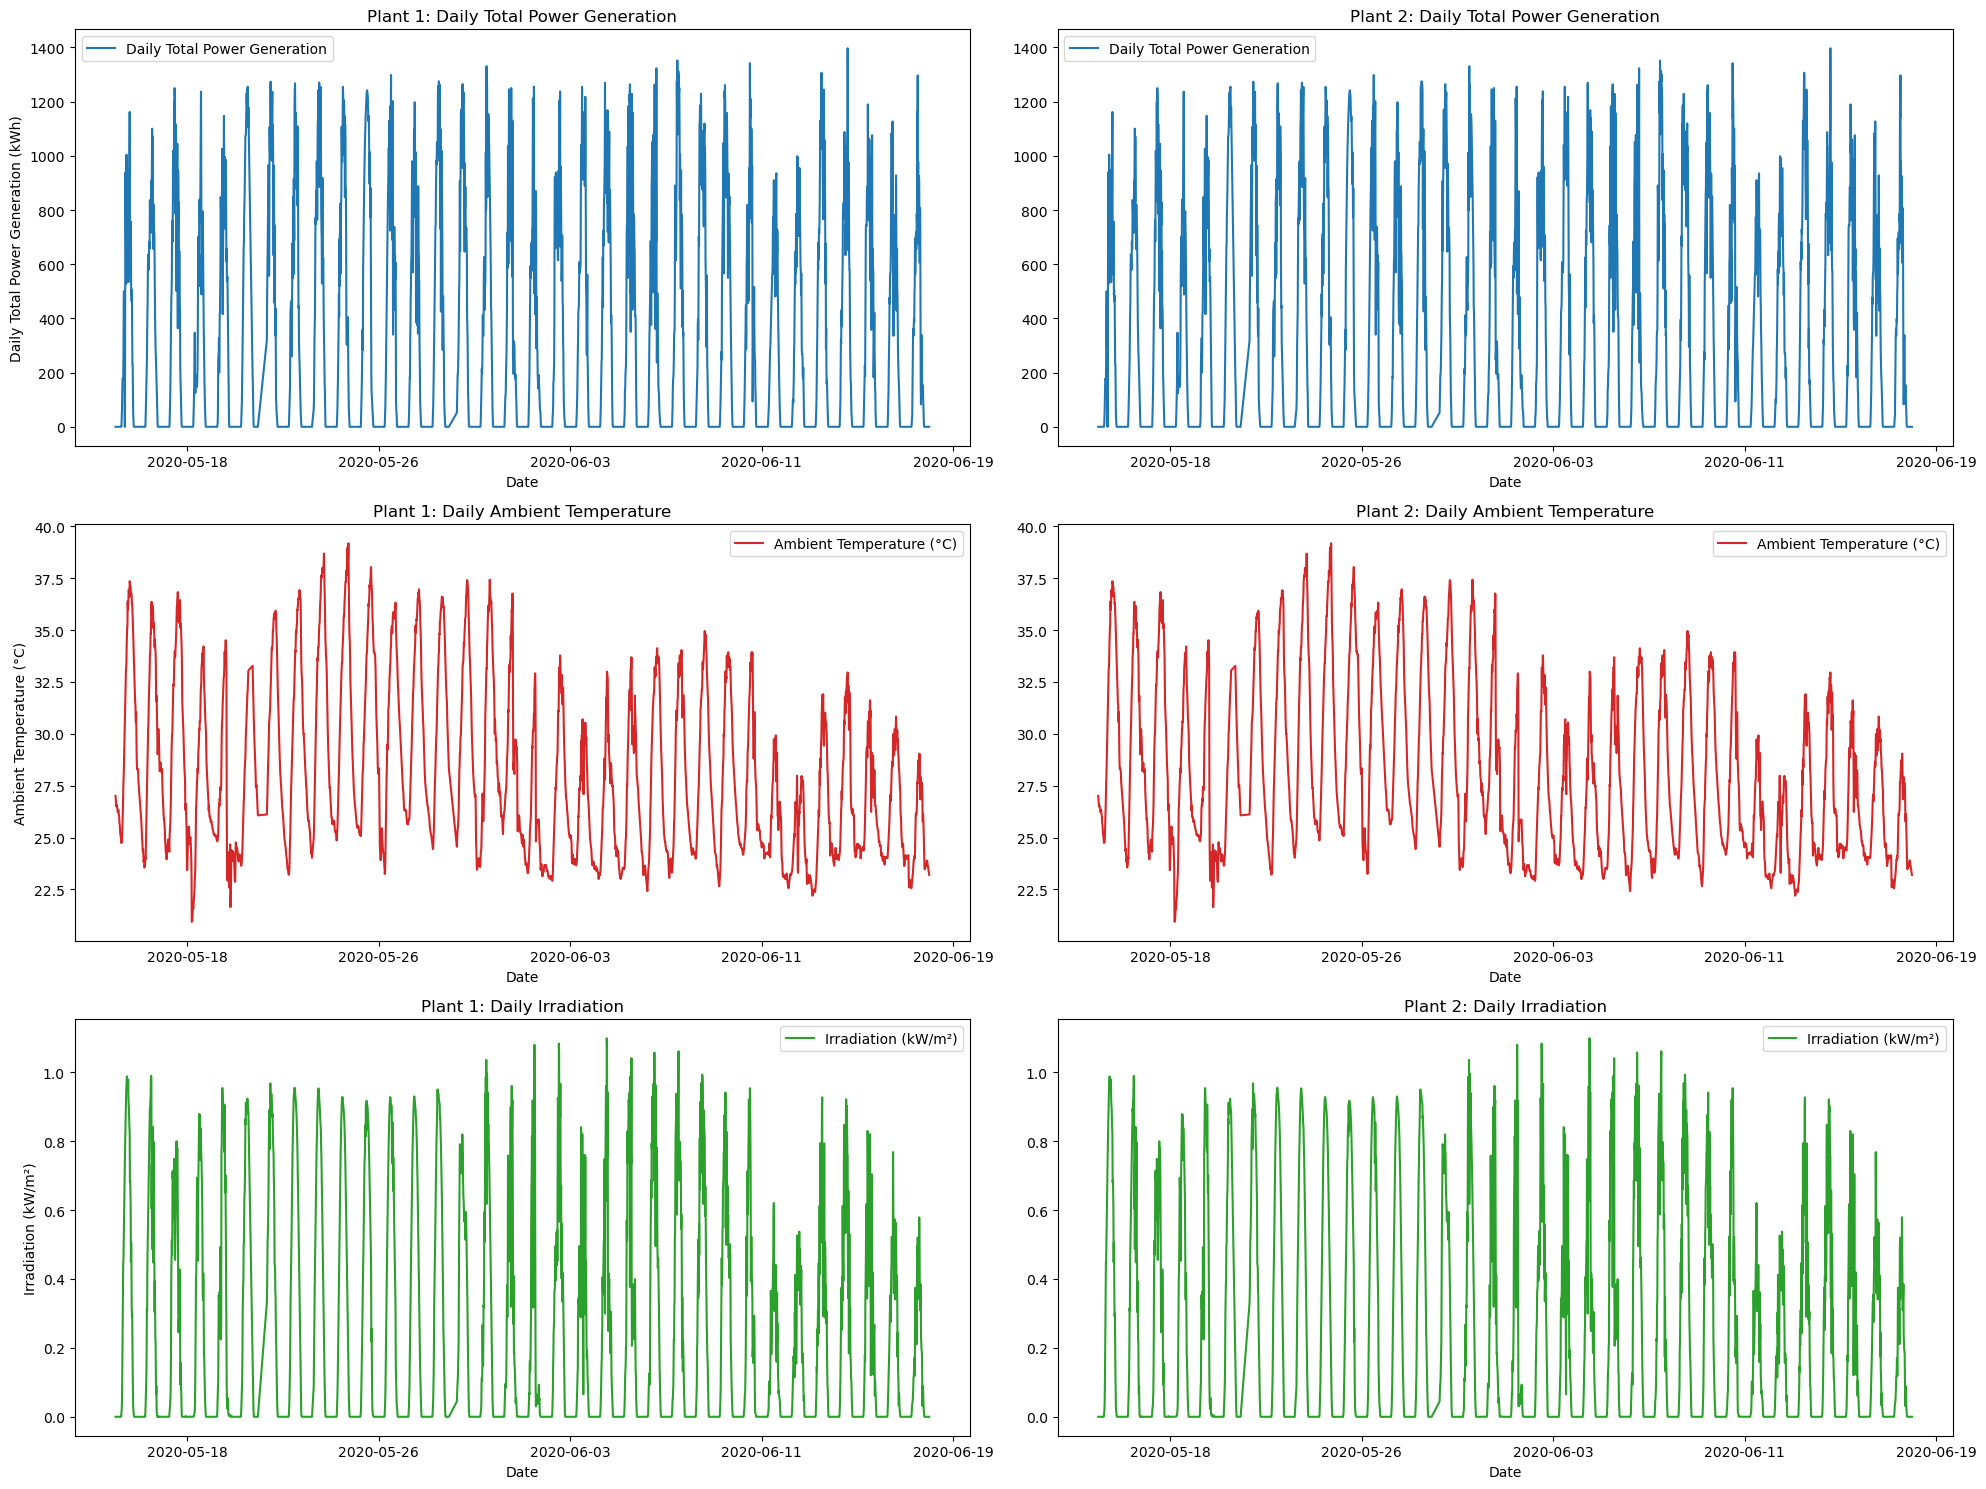

In [16]:
# Adjusting the layout to display Plant 1 and Plant 2 side by side for comparison

# Setting up the plot area for side-by-side comparison
fig, axs = plt.subplots(3, 2, figsize=(20, 15))

# Plant 1 Daily Total Power Generation
axs[0, 0].plot(
    plant_1_data["DATE_TIME"],
    plant_1_data["AC_POWER"],
    color="tab:blue",
    label="Daily Total Power Generation",
)
axs[0, 0].set_title("Plant 1: Daily Total Power Generation")
axs[0, 0].set_ylabel("Daily Total Power Generation (kWh)")
axs[0, 0].legend()

# Plant 2 Daily Total Power Generation
axs[0, 1].plot(
    plant_2_data["DATE_TIME"],
    plant_2_data["AC_POWER"],
    color="tab:blue",
    label="Daily Total Power Generation",
)
axs[0, 1].set_title("Plant 2: Daily Total Power Generation")
axs[0, 1].legend()

# Plant 1 Ambient Temperature
axs[1, 0].plot(
    plant_1_data["DATE_TIME"],
    plant_1_data["AMBIENT_TEMPERATURE"],
    color="tab:red",
    label="Ambient Temperature (°C)",
)
axs[1, 0].set_title("Plant 1: Daily Ambient Temperature")
axs[1, 0].set_ylabel("Ambient Temperature (°C)")
axs[1, 0].legend()

# Plant 2 Ambient Temperature
axs[1, 1].plot(
    plant_2_data["DATE_TIME"],
    plant_2_data["AMBIENT_TEMPERATURE"],
    color="tab:red",
    label="Ambient Temperature (°C)",
)
axs[1, 1].set_title("Plant 2: Daily Ambient Temperature")
axs[1, 1].legend()

# Plant 1 Irradiation
axs[2, 0].plot(
    plant_1_data["DATE_TIME"],
    plant_1_data["IRRADIATION"],
    color="tab:green",
    label="Irradiation (kW/m²)",
)
axs[2, 0].set_title("Plant 1: Daily Irradiation")
axs[2, 0].set_ylabel("Irradiation (kW/m²)")
axs[2, 0].legend()

# Plant 2 Irradiation
axs[2, 1].plot(
    plant_2_data["DATE_TIME"],
    plant_2_data["IRRADIATION"],
    color="tab:green",
    label="Irradiation (kW/m²)",
)
axs[2, 1].set_title("Plant 2: Daily Irradiation")
axs[2, 1].legend()

# Setting up the x-axis labels
for ax in axs.flat:
    ax.set_xlabel("Date")
    ax.xaxis.set_major_locator(
        plt.MaxNLocator(6)
    )  # Limit the number of x-axis labels to make them readable

plt.tight_layout()
plt.show()

### Correlation Matrix


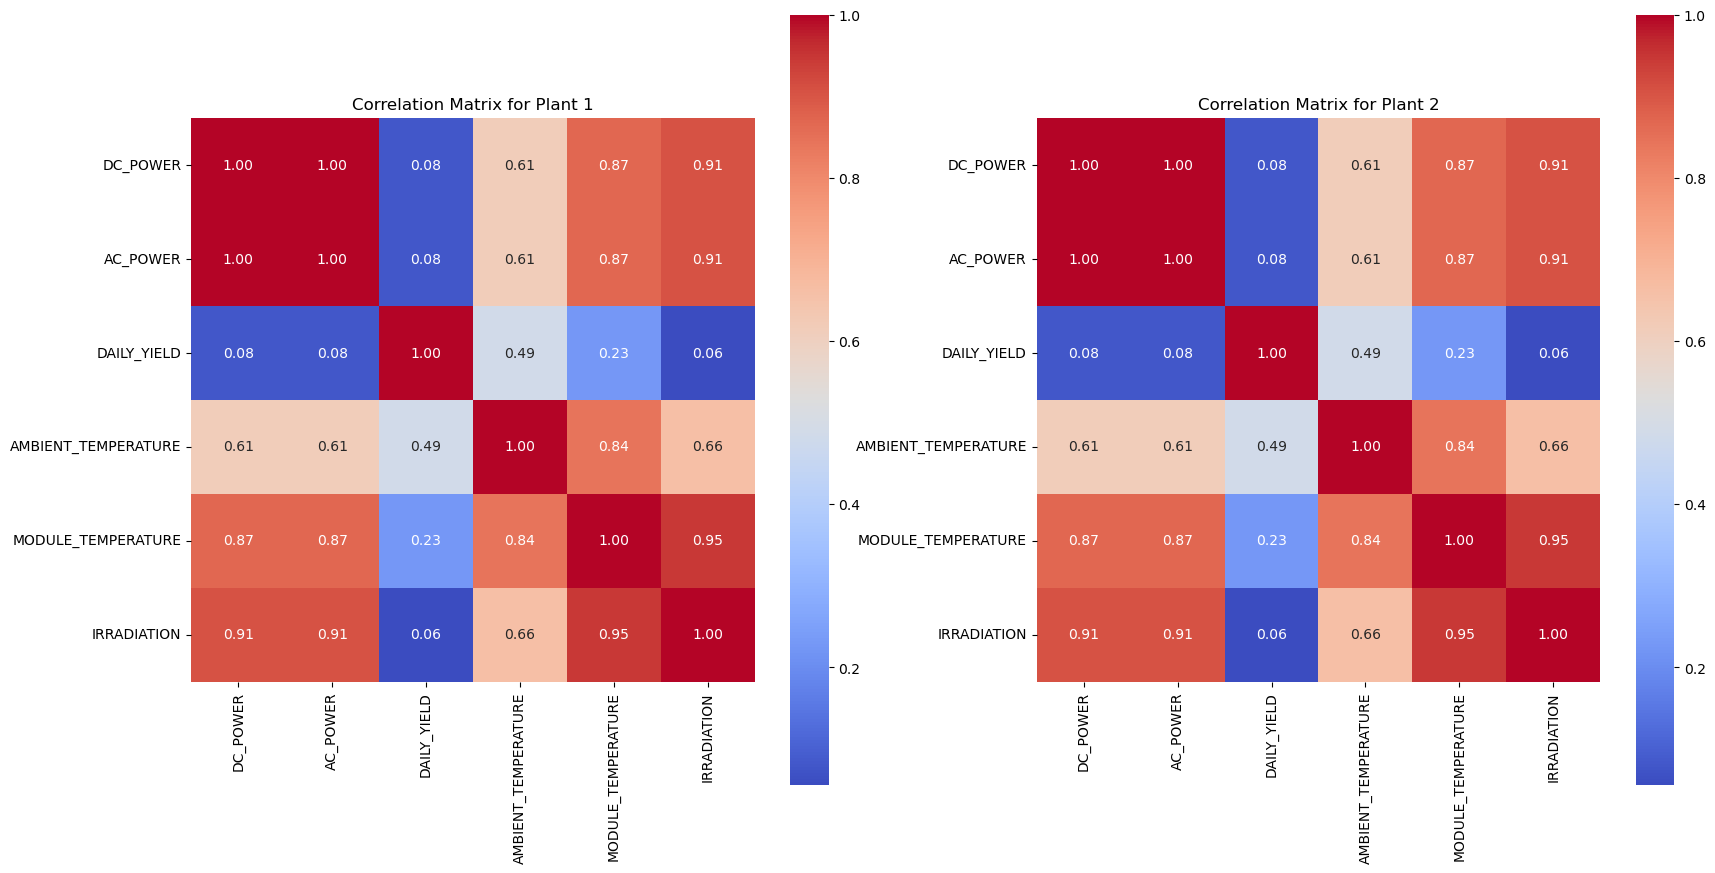

In [17]:
relevant_columns = [
    "DC_POWER",
    "AC_POWER",
    "DAILY_YIELD",
    "AMBIENT_TEMPERATURE",
    "MODULE_TEMPERATURE",
    "IRRADIATION",
]

correlation_matrix_1 = plant_1_data[relevant_columns].corr()
correlation_matrix_2 = plant_2_data[relevant_columns].corr()


plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.heatmap(correlation_matrix_1, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix for Plant 1")

plt.subplot(1, 2, 2)
sns.heatmap(correlation_matrix_2, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix for Plant 2")

plt.show()

In [91]:
data_combined = plant_1_data
data_combined

,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15 00:00:00,27.004764,25.060789,0.0,0.0,0.0,0.0,7116151.0
15,2020-05-15 00:15:00,26.880811,24.421869,0.0,0.0,0.0,0.0,7116151.0
30,2020-05-15 00:30:00,26.682055,24.427290,0.0,0.0,0.0,0.0,7116151.0
45,2020-05-15 00:45:00,26.500589,24.420678,0.0,0.0,0.0,0.0,7116151.0
60,2020-05-15 01:00:00,26.596148,25.088210,0.0,0.0,0.0,0.0,7116151.0
...,...,...,...,...,...,...,...,...
48885,2020-06-17 22:45:00,23.511703,22.856201,0.0,0.0,0.0,5910.0,7363272.0
48900,2020-06-17 23:00:00,23.482282,22.744190,0.0,0.0,0.0,5910.0,7363272.0
48915,2020-06-17 23:15:00,23.354743,22.492245,0.0,0.0,0.0,5910.0,7363272.0
48930,2020-06-17 23:30:00,23.291048,22.373909,0.0,0.0,0.0,5910.0,7363272.0


## Prediction


### Preparation


In [93]:
# Preparing features and target variable
features = data_combined.head(2950)[["AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION"]]
target = data_combined.head(2950)["AC_POWER"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=42
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2065, 3) (2065,)
(885, 3) (885,)


In [92]:
3154-200

2954

In [99]:
data_combined

,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15 00:00:00,27.004764,25.060789,0.0,0.0,0.0,0.0,7116151.0
15,2020-05-15 00:15:00,26.880811,24.421869,0.0,0.0,0.0,0.0,7116151.0
30,2020-05-15 00:30:00,26.682055,24.427290,0.0,0.0,0.0,0.0,7116151.0
45,2020-05-15 00:45:00,26.500589,24.420678,0.0,0.0,0.0,0.0,7116151.0
60,2020-05-15 01:00:00,26.596148,25.088210,0.0,0.0,0.0,0.0,7116151.0
...,...,...,...,...,...,...,...,...
48885,2020-06-17 22:45:00,23.511703,22.856201,0.0,0.0,0.0,5910.0,7363272.0
48900,2020-06-17 23:00:00,23.482282,22.744190,0.0,0.0,0.0,5910.0,7363272.0
48915,2020-06-17 23:15:00,23.354743,22.492245,0.0,0.0,0.0,5910.0,7363272.0
48930,2020-06-17 23:30:00,23.291048,22.373909,0.0,0.0,0.0,5910.0,7363272.0


R2_score of randomforest= 75.34776140833984
R2_score of GBDT= 79.83268284246272


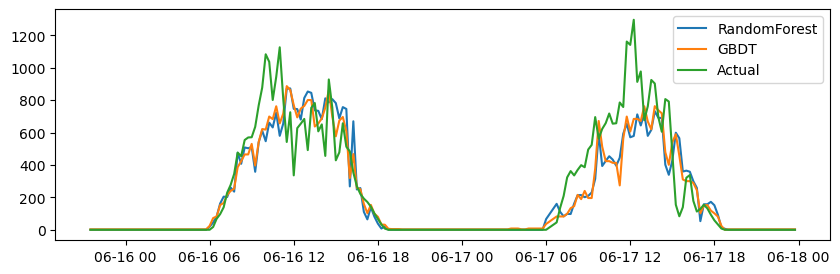

In [110]:
test = data_combined.tail(200)[["AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION"]]
target = data_combined.tail(200)["AC_POWER"]
y_pred_RD = model_RD.predict(scaler.transform(test))
y_pred_GBDT = gbdt_model.predict(scaler.transform(test))

plt.figure(figsize=[10,3])
plt.plot(data_combined["DATE_TIME"].tail(200),y_pred_RD,label= "RandomForest")
plt.plot(data_combined["DATE_TIME"].tail(200),y_pred_GBDT,label = "GBDT")
plt.plot(data_combined["DATE_TIME"].tail(200),target,label = "Actual")
plt.legend()

print("R2_score of randomforest= {}".format(r2_score(target,y_pred_RD) * 100))
print("R2_score of GBDT= {}".format(r2_score(target,y_pred_GBDT) * 100))



In [101]:
# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### SVM


In [102]:
# SVM Model Training
svm_model = SVR(kernel="linear")
svm_model.fit(X_train_scaled, y_train)

# Predictions and Performance Evaluation
y_pred_svm = svm_model.predict(X_test_scaled)

# Calculating R^2 and MSE for the models
svm_score = round(svm_model.score(X_test_scaled, y_test) * 100,2)
svm_r2 = round(r2_score(y_test, y_pred_svm) * 100,2)
mse_svm = mean_squared_error(y_test, y_pred_svm)

print(f"SVM Model score = {svm_score:4.4f}%")
print(f"SVM Model R^2 = {svm_r2:4.4f}")
print(f"SVM Model MSE = {mse_svm:4.4f}")

SVM Model score = 82.3400%
SVM Model R^2 = 82.3400
SVM Model MSE = 28952.0907


### GBDT


In [103]:
# GBDT Model Training
gbdt_model = ensemble.GradientBoostingRegressor()
gbdt_model.fit(X_train_scaled, y_train)

# Predictions and Performance Evaluation
y_pred_gbdt = gbdt_model.predict(X_test_scaled)

# Calculating R^2 and MSE for the models
gbdt_score = gbdt_model.score(X_test_scaled, y_test) * 100
gbdt_r2_score = r2_score(y_test, y_pred_gbdt) * 100
mse_gbdt = mean_squared_error(y_test, y_pred_gbdt)

print(f"GBDT Model score = {gbdt_score:4.4f}%")
print(f"GBDT Model R^2 score = {gbdt_r2_score:4.4f}")
print(f"GBDT Model MSE = {mse_gbdt:4.4f}")

GBDT Model score = 85.2569%
GBDT Model R^2 score = 85.2569
GBDT Model MSE = 24163.7830


In [109]:
model_RD = ensemble.RandomForestRegressor(max_depth=10)
model_RD.fit(X_train_scaled, y_train)

# Predictions and Performance Evaluation
y_pred_RD = model_RD.predict(X_test_scaled)

# Calculating R^2 and MSE for the models
RD_score = model_RD.score(X_test_scaled, y_test) * 100
RD_r2_score = r2_score(y_test, y_pred_RD) * 100
mse_RD = mean_squared_error(y_test, y_pred_RD)

print(f"RandomForestRegressor score = {RD_score:4.4f}%")
print(f"RandomForestRegressor R^2 score = {RD_r2_score:4.4f}")
print(f"RandomForestRegressor MSE = {mse_RD:4.4f}")

RandomForestRegressor score = 85.3047%
RandomForestRegressor R^2 score = 85.3047
RandomForestRegressor MSE = 24085.4713


### NNet


#### Data Transform


In [29]:
X_train_torch = torch.tensor(X_train_scaled.astype(np.float32))
y_train_torch = torch.tensor(y_train.values.astype(np.float32))
X_test_torch = torch.tensor(X_test_scaled.astype(np.float32))
y_test_torch = torch.tensor(y_test.values.astype(np.float32))


train_data = TensorDataset(X_train_torch, y_train_torch)
test_data = TensorDataset(X_test_torch, y_test_torch)

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [35]:
X_train_scaled

array([[-1.01177927, -0.81745156, -0.75823625],
       [-0.05448185,  0.05996639,  0.46352641],
       [-0.61391544, -0.75507641, -0.75823625],
       ...,
       [ 1.27299087,  0.49530094,  0.086403  ],
       [ 0.39976101,  0.90870504,  1.33972436],
       [ 2.52150142,  0.77900387, -0.21469529]])

#### Model


In [34]:
class NNet(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(NNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, 128)
        self.fc4 = nn.ReLU()
        self.fc5 = nn.Linear(128, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        return x


model = NNet(3, 64, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 200
for epoch in range(epochs):
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.view(-1, 1))
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


# Model Evaluation
model.eval()
predictions = []
targets = []

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        predictions.extend(output.view(-1).tolist())
        targets.extend(target.tolist())

nnet_r2 = r2_score(targets, predictions) * 100
print(f"NNet R^2 Score: {nnet_r2}")

Epoch 1, Loss: 319240.5
Epoch 2, Loss: 257844.8125
Epoch 3, Loss: 117097.0
Epoch 4, Loss: 40650.0546875
Epoch 5, Loss: 38489.37109375
Epoch 6, Loss: 28886.24609375
Epoch 7, Loss: 29882.505859375
Epoch 8, Loss: 20508.01953125
Epoch 9, Loss: 29713.599609375
Epoch 10, Loss: 33413.13671875
Epoch 11, Loss: 32601.830078125
Epoch 12, Loss: 14016.2529296875
Epoch 13, Loss: 25629.82421875
Epoch 14, Loss: 28038.9765625
Epoch 15, Loss: 18469.2890625
Epoch 16, Loss: 12410.013671875
Epoch 17, Loss: 27042.302734375
Epoch 18, Loss: 22319.50390625
Epoch 19, Loss: 27326.818359375
Epoch 20, Loss: 23168.7109375
Epoch 21, Loss: 26735.01171875
Epoch 22, Loss: 12838.201171875
Epoch 23, Loss: 9396.8310546875
Epoch 24, Loss: 27521.0
Epoch 25, Loss: 15341.328125
Epoch 26, Loss: 25126.494140625
Epoch 27, Loss: 21078.408203125
Epoch 28, Loss: 9129.7626953125
Epoch 29, Loss: 13253.7646484375
Epoch 30, Loss: 11390.0166015625
Epoch 31, Loss: 14974.5546875
Epoch 32, Loss: 29396.0
Epoch 33, Loss: 36617.8515625
Epoch 

In [120]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.hidden2out = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        lstm_out, _ = self.lstm(input.view(len(input), 1, -1))
        output = self.hidden2out(lstm_out.view(len(input), -1))
        return output


model = LSTM(3, 128, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 200
for epoch in range(epochs):
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.view(-1, 1))
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


# Model Evaluation
model.eval()
predictions = []
targets = []

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        predictions.extend(output.view(-1).tolist())
        targets.extend(target.tolist())

lstm_r2 = r2_score(targets, predictions) * 100
print(f"LSTM R^2 Score: {lstm_r2}")

Epoch 1, Loss: 155768.9375
Epoch 2, Loss: 261786.078125
Epoch 3, Loss: 193955.078125
Epoch 4, Loss: 201599.25
Epoch 5, Loss: 194608.234375
Epoch 6, Loss: 249460.453125
Epoch 7, Loss: 226782.453125
Epoch 8, Loss: 197960.3125
Epoch 9, Loss: 172355.625
Epoch 10, Loss: 197281.140625
Epoch 11, Loss: 218287.90625
Epoch 12, Loss: 265323.9375
Epoch 13, Loss: 255511.015625
Epoch 14, Loss: 182608.0625
Epoch 15, Loss: 174766.515625
Epoch 16, Loss: 170503.296875
Epoch 17, Loss: 238501.015625
Epoch 18, Loss: 169930.1875
Epoch 19, Loss: 312860.34375
Epoch 20, Loss: 259815.015625
Epoch 21, Loss: 269330.4375
Epoch 22, Loss: 113070.078125
Epoch 23, Loss: 190770.546875
Epoch 24, Loss: 223358.09375
Epoch 25, Loss: 145986.984375
Epoch 26, Loss: 169999.796875
Epoch 27, Loss: 124043.3359375
Epoch 28, Loss: 125974.90625
Epoch 29, Loss: 174941.4375
Epoch 30, Loss: 132250.71875
Epoch 31, Loss: 129599.0390625
Epoch 32, Loss: 121399.9453125
Epoch 33, Loss: 147204.25
Epoch 34, Loss: 109365.3046875
Epoch 35, Loss: